# Transformer Blocks & Wiederholbarkeit

Dieses Notebook erklaert:
1. **Inference-Pipeline**: Token → Embedding → Transformer Blocks → Logits → Softmax → Token
2. **Transformer Blocks**: Was passiert in jedem Block und warum braucht man mehrere?
3. **Wiederholbarkeit**: Warum liefert dasselbe Modell mit demselben Prompt unterschiedliche Ergebnisse?
4. **Floating-Point-Arithmetik**: Warum `(a + b) + c != a + (b + c)` auf dem Computer
5. **GPU-Parallelismus & Tiling**: Wie `num_ctx` die Berechnung beeinflusst
6. **Determinismus-Rezept**: `temperature=0` + `seed` + fester `num_ctx`

In [19]:
import sys
from pathlib import Path

src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import json
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

from training.training_transformer import load_transformer_model

plt.style.use('dark_background')
plt.rcParams.update({'axes.grid': True, 'grid.alpha': 0.3})

print("Bibliotheken geladen!")

Bibliotheken geladen!


In [20]:
model_dir = Path("../dist/transformer_model")

if not model_dir.exists():
    raise FileNotFoundError(f"Modell nicht gefunden: {model_dir}\nBitte erst trainieren: python src/main.py")

model, tokenizer = load_transformer_model(str(model_dir))
model.eval()

print(f"Modell:     MiniGPT")
print(f"Vokabular:  {tokenizer.vocab_size} Tokens")
print(f"Embed-Dim:  {model.embed_dim}")
print(f"Blocks:     {len(model.blocks)}")
print(f"Heads:      {model.blocks[0].attention.num_heads}")

🤖 MiniGPT erstellt:
   - Vokabular: 69 Tokens
   - Embedding: 64D
   - Attention Heads: 1
   - Transformer Layers: 2
✅ Transformer-Modell geladen aus: ..\dist\transformer_model
Modell:     MiniGPT
Vokabular:  69 Tokens
Embed-Dim:  64
Blocks:     2
Heads:      1


---
## 1. Die Inference-Pipeline

Bei **jeder** Token-Generierung wird das komplette Netz einmal durchlaufen.
Logits werden **nicht** gespeichert – sie werden jedes Mal frisch berechnet.

```
Input: "die katze"                 (String)
        ↓
   [Tokenisierung]                  String → Token-IDs
        ↓
   Token-IDs: [12, 5]               (Integer-Array)
        ↓
   [Embedding-Lookup]               Token-ID → Vektor (gespeicherte Gewichte)
        ↓
   [Positional Encoding]            Position im Satz eincodieren
        ↓
   [Transformer Block 1]            Attention + FeedForward (Gewichte)
        ↓
   [Transformer Block 2]            Attention + FeedForward (Gewichte)
        ↓
   [Transformer Block N ...]        je mehr Blocks, desto "schlauer"
        ↓
   [LayerNorm]
        ↓
   [Projektion auf Vokabular]       Matrix: embed_dim × vocab_size
        ↓
   Logits: [2.1, -0.5, 8.7, ...]   (ein Score pro Token im Vokabular)
        ↓
   [Softmax + Sampling]             Logits → Wahrscheinlichkeiten → Auswahl
        ↓
   Output-Token: "sitzt"            (ein neues Token)
```

**Gespeichert** (Gewichte, ~8 GB bei einem 8B-Modell): Embedding-Matrix, Attention-Gewichte (Q, K, V), Feed-Forward-Gewichte

**Berechnet** (pro Token, fluechtiger): Zwischenaktivierungen, KV-Cache, Logits

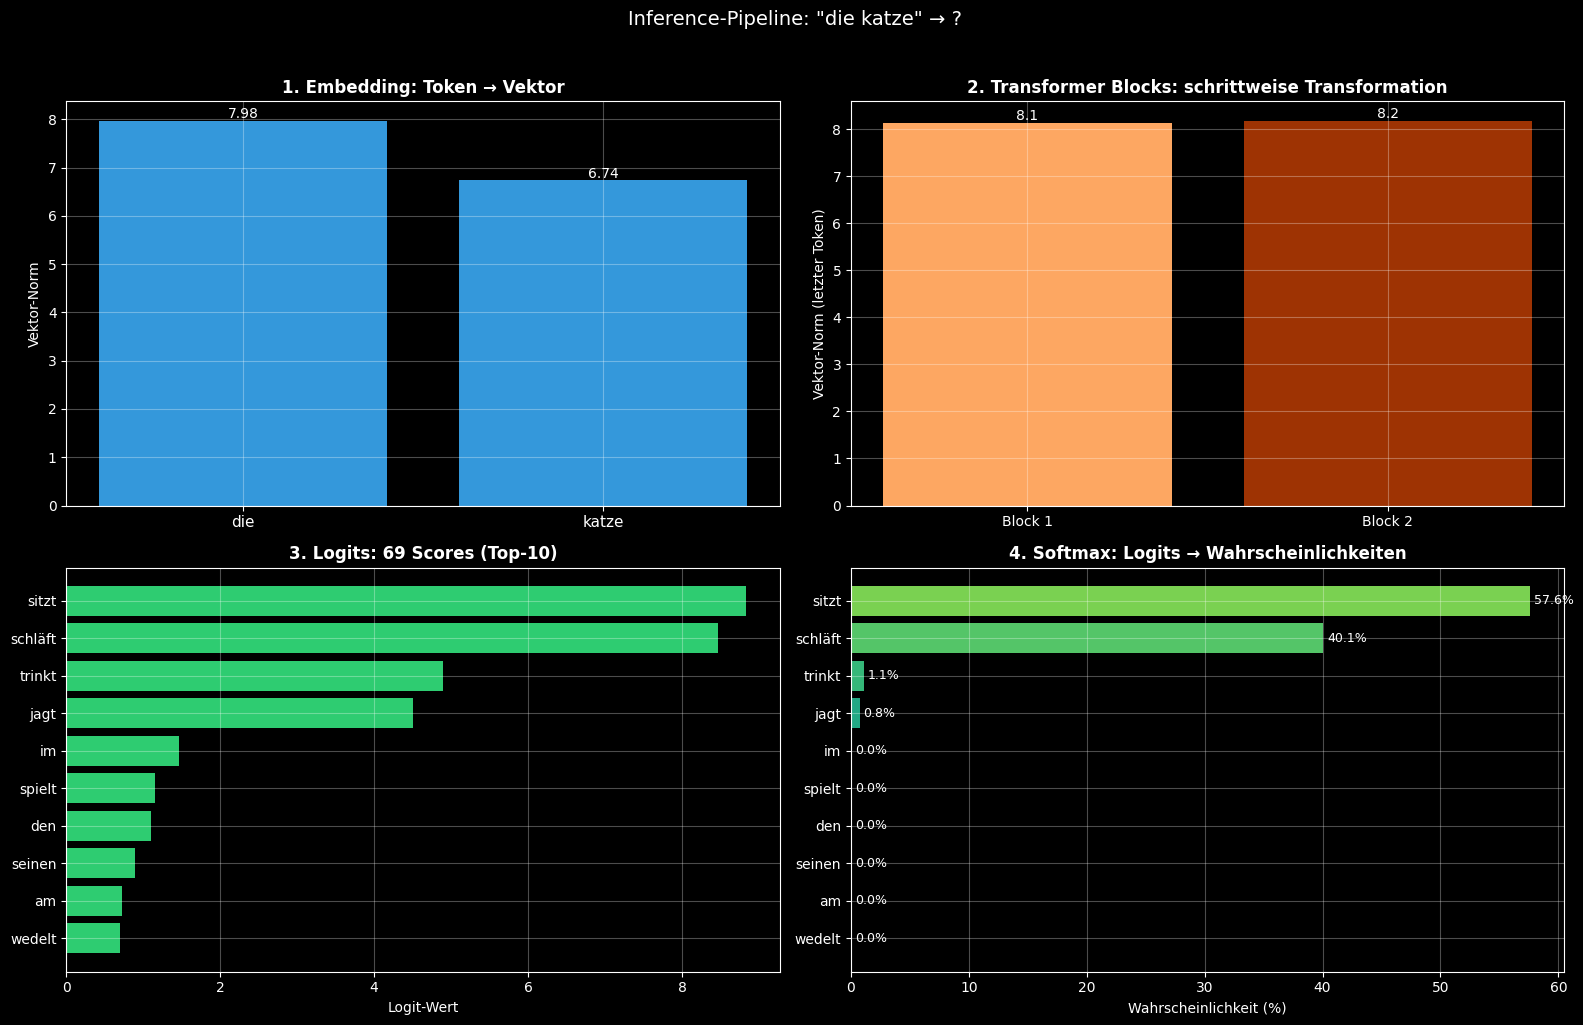

In [21]:
def visualize_inference_pipeline(model, tokenizer, text):
    """Zeigt die komplette Inference-Pipeline mit Zwischenergebnissen."""
    model.eval()
    tokens = tokenizer.encode(text)
    words = text.lower().split()

    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)

        # 1. Embedding
        embedded = model.token_embedding(input_tensor)
        embed_norms = embedded[0].norm(dim=-1).numpy()

        # 2. Positional Encoding
        pos_encoded = embedded + model.pos_encoding.pe[:, :len(tokens), :]

        # 3. Durch jeden Block
        block_outputs = []
        x = pos_encoded
        for block in model.blocks:
            x = block(x)
            block_outputs.append(x[0, -1, :].numpy().copy())

        # 4. LayerNorm + Projektion
        x = model.ln_final(x)
        logits = model.lm_head(x)
        last_logits = logits[0, -1, :].numpy()
        probs = F.softmax(torch.tensor(last_logits), dim=-1).numpy()

    # --- Visualisierung ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. Embedding-Normen pro Token
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(words)), embed_norms, color='#3498db')
    ax1.set_xticks(range(len(words)))
    ax1.set_xticklabels(words, fontsize=11)
    ax1.set_ylabel('Vektor-Norm')
    ax1.set_title('1. Embedding: Token → Vektor', fontweight='bold')
    for bar, norm in zip(bars, embed_norms):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{norm:.2f}', ha='center', fontsize=10)

    # 2. Block-Outputs: Wie veraendert sich der Vektor?
    ax2 = axes[0, 1]
    block_norms = [np.linalg.norm(bo) for bo in block_outputs]
    colors_block = plt.cm.Oranges(np.linspace(0.4, 0.9, len(block_outputs)))
    bars2 = ax2.bar(range(len(block_outputs)), block_norms, color=colors_block)
    ax2.set_xticks(range(len(block_outputs)))
    ax2.set_xticklabels([f'Block {i+1}' for i in range(len(block_outputs))])
    ax2.set_ylabel('Vektor-Norm (letzter Token)')
    ax2.set_title('2. Transformer Blocks: schrittweise Transformation', fontweight='bold')
    for bar, norm in zip(bars2, block_norms):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{norm:.1f}', ha='center', fontsize=10)

    # 3. Logits (Top-10)
    ax3 = axes[1, 0]
    top_k = 10
    top_idx = np.argsort(last_logits)[-top_k:][::-1]
    top_logits = last_logits[top_idx]
    top_words = [tokenizer.idx_to_word.get(i, '?') for i in top_idx]
    colors_l = ['#2ecc71' if l > 0 else '#e74c3c' for l in top_logits]
    ax3.barh(range(top_k), top_logits, color=colors_l)
    ax3.set_yticks(range(top_k))
    ax3.set_yticklabels(top_words)
    ax3.set_xlabel('Logit-Wert')
    ax3.set_title(f'3. Logits: {tokenizer.vocab_size} Scores (Top-{top_k})', fontweight='bold')
    ax3.invert_yaxis()
    ax3.axvline(x=0, color='white', linestyle='--', alpha=0.3)

    # 4. Wahrscheinlichkeiten nach Softmax
    ax4 = axes[1, 1]
    top_probs = probs[top_idx]
    colors_p = plt.cm.viridis(np.linspace(0.8, 0.2, top_k))
    bars4 = ax4.barh(range(top_k), top_probs * 100, color=colors_p)
    ax4.set_yticks(range(top_k))
    ax4.set_yticklabels(top_words)
    ax4.set_xlabel('Wahrscheinlichkeit (%)')
    ax4.set_title('4. Softmax: Logits → Wahrscheinlichkeiten', fontweight='bold')
    ax4.invert_yaxis()
    for bar, p in zip(bars4, top_probs):
        ax4.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{p*100:.1f}%', va='center', fontsize=9)

    plt.suptitle(f'Inference-Pipeline: "{text}" → ?', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_inference_pipeline(model, tokenizer, "die katze")

---
## 2. Transformer Blocks: Warum braucht man mehrere?

Die **letzte Schicht** (Projektion auf Vokabular) ist nur eine lineare Transformation:
`Logits = Gewichtsmatrix × Eingabevektor` – sie kann keine Zusammenhaenge erkennen.

Die **Transformer Blocks** transformieren den Input schrittweise in etwas Bedeutungsvolles:

| Block-Bereich | Was passiert |
|---|---|
| Fruehe Blocks (1-4) | Syntaktische Muster: "Das ist ein Wort, das ist ein anderes" |
| Mittlere Blocks (5-20) | Semantische Zusammenhaenge: "Hauptstadt" + "Frankreich" gehoeren zusammen |
| Spaete Blocks (21-32) | Entscheidung: "Der naechste Token sollte 'Paris' sein" |

Jeder Block besteht aus:
1. **Multi-Head Attention**: Welche Tokens im Kontext sind fuer den naechsten relevant?
2. **LayerNorm + Residual**: Stabilisierung
3. **Feed-Forward (GELU)**: Nicht-lineare Transformation
4. **LayerNorm + Residual**: Stabilisierung

Unser MiniGPT hat nur 2 Blocks – grosse Modelle (GPT-4, Llama 3) haben 32-96 Blocks.

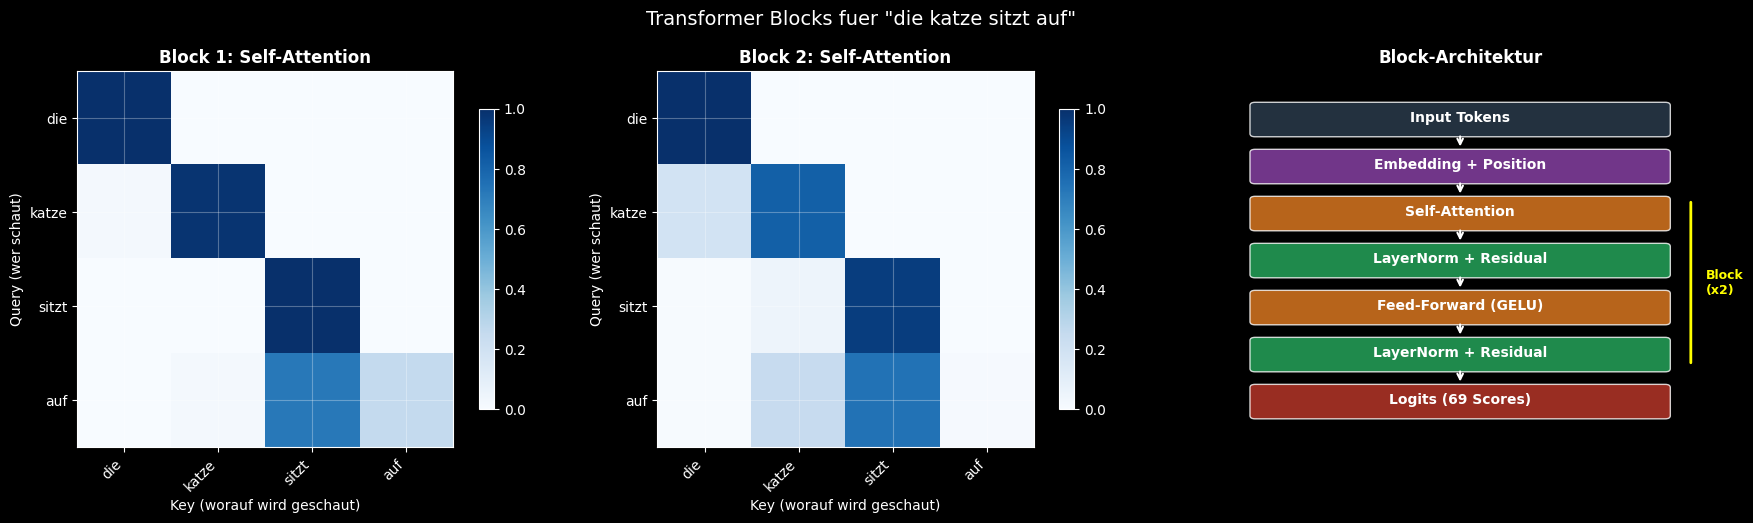

In [22]:
def visualize_block_internals(model, tokenizer, text):
    """Zeigt was in jedem Transformer Block passiert – mit Attention-Weights."""
    model.eval()
    tokens = tokenizer.encode(text)
    words = text.lower().split()

    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)
        _ = model(input_tensor)

    attention_weights = model.get_attention_weights()
    num_blocks = len(attention_weights)

    fig, axes = plt.subplots(1, num_blocks + 1, figsize=(6 * (num_blocks + 1), 5))

    # Attention-Heatmaps pro Block
    for i, layer_weights in enumerate(attention_weights):
        ax = axes[i]
        avg_weights = layer_weights[0].mean(dim=0).numpy()
        im = ax.imshow(avg_weights, cmap='Blues', vmin=0, vmax=1)
        ax.set_xticks(range(len(words)))
        ax.set_yticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45, ha='right')
        ax.set_yticklabels(words)
        ax.set_xlabel('Key (worauf wird geschaut)')
        ax.set_ylabel('Query (wer schaut)')
        ax.set_title(f'Block {i+1}: Self-Attention', fontweight='bold')
        plt.colorbar(im, ax=ax, shrink=0.8)

    # Architektur-Diagramm
    ax_arch = axes[-1]
    ax_arch.set_xlim(0, 10)
    ax_arch.set_ylim(0, 12)
    ax_arch.axis('off')
    ax_arch.set_title('Block-Architektur', fontweight='bold')

    components = [
        (10.5, '#2c3e50', 'Input Tokens'),
        (9.0, '#8e44ad', 'Embedding + Position'),
        (7.5, '#e67e22', 'Self-Attention'),
        (6.0, '#27ae60', 'LayerNorm + Residual'),
        (4.5, '#e67e22', 'Feed-Forward (GELU)'),
        (3.0, '#27ae60', 'LayerNorm + Residual'),
        (1.5, '#c0392b', f'Logits ({tokenizer.vocab_size} Scores)'),
    ]

    for y, color, label in components:
        rect = FancyBboxPatch((1, y - 0.5), 8, 0.9, boxstyle='round,pad=0.1',
                             facecolor=color, edgecolor='white', alpha=0.8)
        ax_arch.add_patch(rect)
        ax_arch.text(5, y, label, ha='center', va='center',
                    fontsize=10, color='white', fontweight='bold')

    # Pfeile
    for i in range(len(components) - 1):
        y_from = components[i][0] - 0.5
        y_to = components[i+1][0] + 0.5
        ax_arch.annotate('', xy=(5, y_to), xytext=(5, y_from),
                        arrowprops=dict(arrowstyle='->', color='white', lw=1.5))

    # Klammer fuer "Block"
    ax_arch.annotate('', xy=(9.5, 7.5 + 0.4), xytext=(9.5, 3.0 - 0.4),
                    arrowprops=dict(arrowstyle='-', color='yellow', lw=2))
    ax_arch.text(9.8, 5.25, f'Block\n(x{num_blocks})', fontsize=9,
                color='yellow', va='center', fontweight='bold')

    plt.suptitle(f'Transformer Blocks fuer "{text}"', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_block_internals(model, tokenizer, "die katze sitzt auf")

### Ohne Transformer Blocks: Nur Embedding → Projektion

Was passiert, wenn wir die Blocks ueberspringen und direkt vom Embedding auf das Vokabular projizieren?

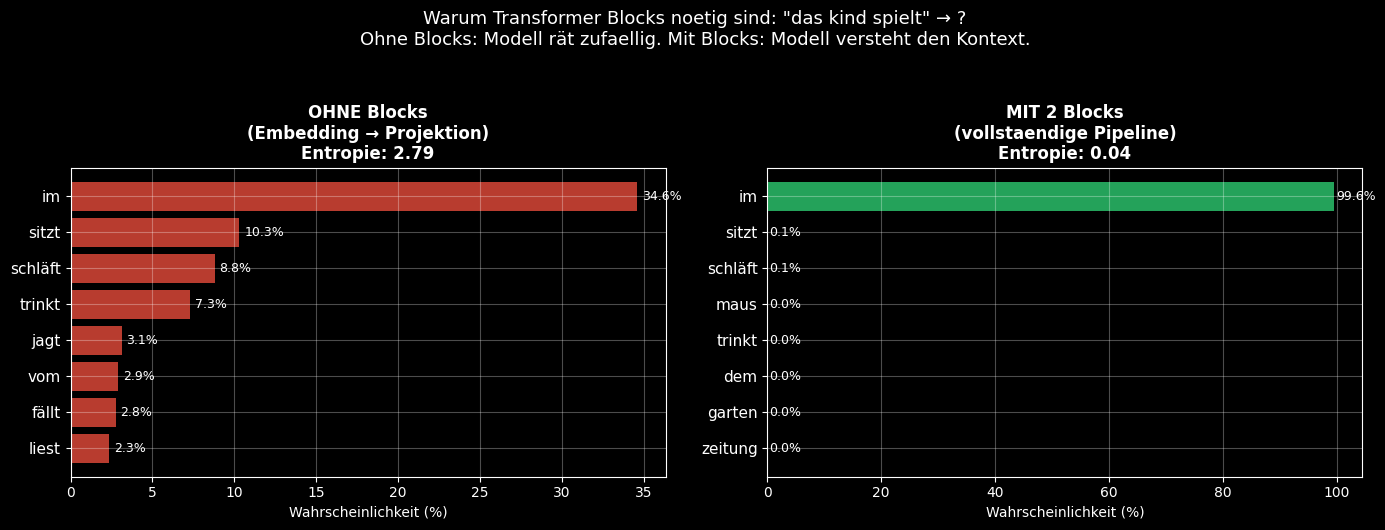

In [23]:
def compare_with_without_blocks(model, tokenizer, text, top_k=8):
    """Vergleicht Vorhersagen mit vs. ohne Transformer Blocks."""
    model.eval()
    tokens = tokenizer.encode(text)

    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)

        # MIT Blocks (normal)
        logits_full = model(input_tensor)
        probs_full = F.softmax(logits_full[0, -1, :], dim=-1).numpy()

        # OHNE Blocks (Embedding direkt → Projektion)
        embedded = model.token_embedding(input_tensor)
        embedded = embedded + model.pos_encoding.pe[:, :len(tokens), :]
        logits_skip = model.lm_head(model.ln_final(embedded))
        probs_skip = F.softmax(logits_skip[0, -1, :], dim=-1).numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    for ax, probs, title, color in [
        (ax1, probs_skip, 'OHNE Blocks\n(Embedding → Projektion)', '#e74c3c'),
        (ax2, probs_full, f'MIT {len(model.blocks)} Blocks\n(vollstaendige Pipeline)', '#2ecc71'),
    ]:
        top_idx = np.argsort(probs)[-top_k:][::-1]
        top_p = probs[top_idx]
        top_w = [tokenizer.idx_to_word.get(i, '?') for i in top_idx]

        # Entropie berechnen
        entropy = -np.sum(probs * np.log(probs + 1e-10))

        bars = ax.barh(range(top_k), top_p * 100, color=color, alpha=0.8)
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(top_w, fontsize=11)
        ax.set_xlabel('Wahrscheinlichkeit (%)')
        ax.set_title(f'{title}\nEntropie: {entropy:.2f}', fontweight='bold')
        ax.invert_yaxis()
        for bar, p in zip(bars, top_p):
            ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                    f'{p*100:.1f}%', va='center', fontsize=9)

    plt.suptitle(f'Warum Transformer Blocks noetig sind: "{text}" → ?\n'
                 f'Ohne Blocks: Modell rät zufaellig. Mit Blocks: Modell versteht den Kontext.',
                 fontsize=13, y=1.05)
    plt.tight_layout()
    plt.show()

compare_with_without_blocks(model, tokenizer, "die katze")
compare_with_without_blocks(model, tokenizer, "das kind spielt")

---
## 3. Wiederholbarkeit: Das Determinismus-Problem

Fuer **deterministische** LLM-Ausgaben muessen drei Parameter zusammenspielen:

| Parameter | Wert | Warum |
|---|---|---|
| `temperature` | `0` | Entfernt Zufaelligkeit – immer das wahrscheinlichste Token (Greedy Decoding) |
| `seed` | fester Integer, z.B. `123` | Fixiert den Zufallsgenerator |
| `num_ctx` | fester Wert, z.B. `2048` | Identisches Speicher-Layout → identische Float-Berechnungen |

### Warum reicht `temperature=0` allein nicht?

Selbst bei Greedy Decoding (immer das Top-Token) koennen minimale Floating-Point-Unterschiede
die Rangfolge zweier fast gleichwertiger Tokens kippen:

```
Run 1:  token="blau"  logprob=-1.3841   ← Gewinner
        token="klar"  logprob=-1.3842

Run 2:  token="klar"  logprob=-1.3841   ← Gewinner (!)  
        token="blau"  logprob=-1.3842
```

Ab diesem einen abweichenden Token divergiert die **gesamte** restliche Generierung,
weil jedes folgende Token auf einem anderen Kontext aufbaut.

In [24]:
def demonstrate_temperature_determinism(model, tokenizer, text, num_runs=5):
    """Demonstriert: temperature=0 → deterministisch, temperature>0 → variabel."""
    model.eval()
    tokens = tokenizer.encode(text)

    results = {'greedy': [], 'sampled': []}

    for _ in range(num_runs):
        with torch.no_grad():
            input_tensor = torch.tensor(tokens).unsqueeze(0)
            logits = model(input_tensor)[0, -1, :]

            # Greedy (temp=0): immer Top-Token
            greedy_token = torch.argmax(logits).item()
            results['greedy'].append(tokenizer.idx_to_word.get(greedy_token, '?'))

            # Sampling (temp=0.8): zufaellig gewichtet
            scaled = logits / 0.8
            probs = F.softmax(scaled, dim=-1)
            sampled_token = torch.multinomial(probs, 1).item()
            results['sampled'].append(tokenizer.idx_to_word.get(sampled_token, '?'))

    print(f'Eingabe: "{text}"')
    print(f'  temp=0 (greedy):  {results["greedy"]}  → alle gleich? {len(set(results["greedy"])) == 1}')
    print(f'  temp=0.8 (sample): {results["sampled"]}  → alle gleich? {len(set(results["sampled"])) == 1}')
    print()

demonstrate_temperature_determinism(model, tokenizer, "die katze", num_runs=8)
demonstrate_temperature_determinism(model, tokenizer, "der hund", num_runs=8)

Eingabe: "die katze"
  temp=0 (greedy):  ['sitzt', 'sitzt', 'sitzt', 'sitzt', 'sitzt', 'sitzt', 'sitzt', 'sitzt']  → alle gleich? True
  temp=0.8 (sample): ['schläft', 'schläft', 'schläft', 'sitzt', 'sitzt', 'schläft', 'sitzt', 'sitzt']  → alle gleich? False

Eingabe: "der hund"
  temp=0 (greedy):  ['wedelt', 'wedelt', 'wedelt', 'wedelt', 'wedelt', 'wedelt', 'wedelt', 'wedelt']  → alle gleich? True
  temp=0.8 (sample): ['wedelt', 'spielt', 'wedelt', 'frisst', 'wedelt', 'wedelt', 'spielt', 'läuft']  → alle gleich? False



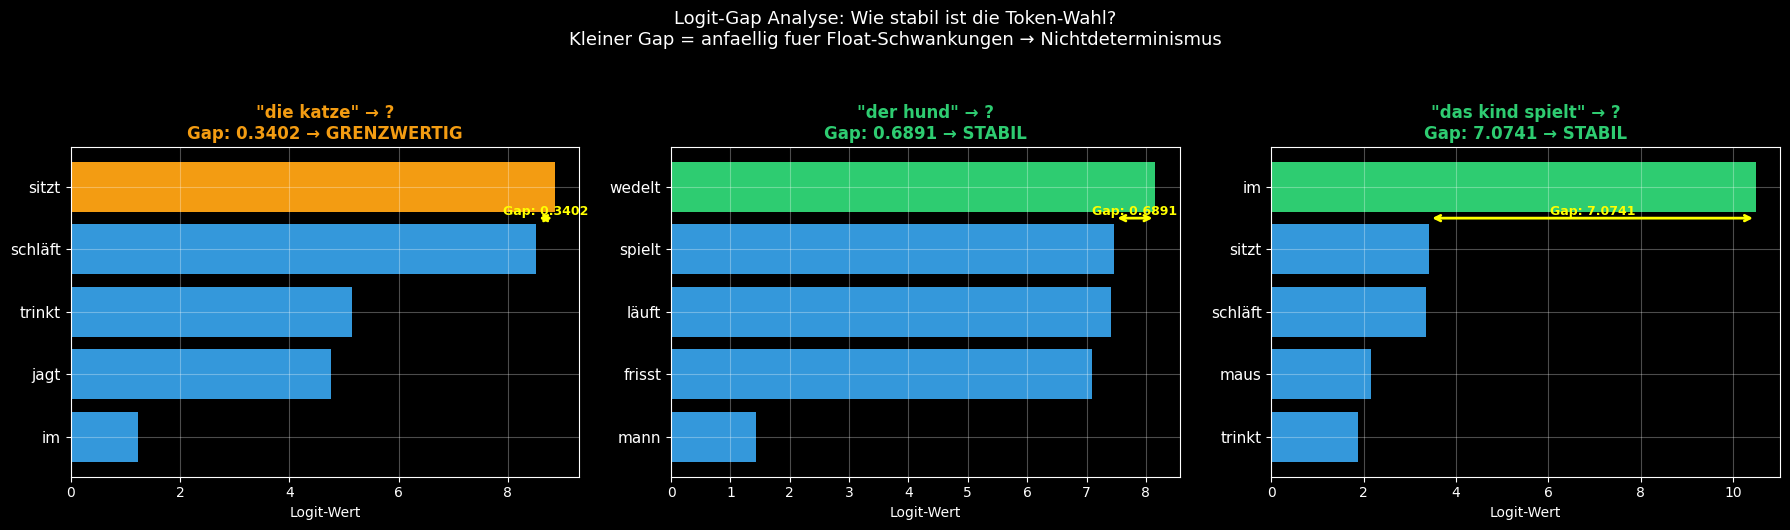

In [25]:
def show_logit_gaps(model, tokenizer, texts, top_k=5):
    """Zeigt den Logit-Abstand zwischen Top-1 und Top-2 Token.
    
    Kleiner Gap = instabil (anfaellig fuer Nichtdeterminismus)
    Grosser Gap = stabil (deterministisch auch bei Float-Schwankungen)
    """
    model.eval()

    fig, axes = plt.subplots(1, len(texts), figsize=(6 * len(texts), 5))
    if len(texts) == 1:
        axes = [axes]

    for ax, text in zip(axes, texts):
        tokens = tokenizer.encode(text)
        with torch.no_grad():
            logits = model(torch.tensor(tokens).unsqueeze(0))[0, -1, :].numpy()

        top_idx = np.argsort(logits)[-top_k:][::-1]
        top_logits = logits[top_idx]
        top_words = [tokenizer.idx_to_word.get(i, '?') for i in top_idx]

        # Gap zwischen #1 und #2
        gap = top_logits[0] - top_logits[1]
        stability = 'STABIL' if gap > 0.5 else 'INSTABIL' if gap < 0.1 else 'GRENZWERTIG'
        stability_color = '#2ecc71' if gap > 0.5 else '#e74c3c' if gap < 0.1 else '#f39c12'

        colors = [stability_color if i == 0 else '#3498db' for i in range(top_k)]
        bars = ax.barh(range(top_k), top_logits, color=colors)
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(top_words, fontsize=11)
        ax.set_xlabel('Logit-Wert')
        ax.set_title(f'"{text}" → ?\nGap: {gap:.4f} → {stability}',
                    fontweight='bold', color=stability_color)
        ax.invert_yaxis()

        # Gap-Annotation
        ax.annotate('', xy=(top_logits[1], 0.5), xytext=(top_logits[0], 0.5),
                   arrowprops=dict(arrowstyle='<->', color='yellow', lw=2))
        ax.text((top_logits[0] + top_logits[1]) / 2, 0.5,
               f'Gap: {gap:.4f}', ha='center', va='bottom',
               fontsize=9, color='yellow', fontweight='bold')

    plt.suptitle('Logit-Gap Analyse: Wie stabil ist die Token-Wahl?\n'
                 'Kleiner Gap = anfaellig fuer Float-Schwankungen → Nichtdeterminismus',
                 fontsize=13, y=1.05)
    plt.tight_layout()
    plt.show()

show_logit_gaps(model, tokenizer, ["die katze", "der hund", "das kind spielt"])

---
## 4. Floating-Point-Arithmetik: Warum `(a + b) + c ≠ a + (b + c)`

Computer rechnen mit endlicher Praezision (float32 ≈ 7 Dezimalstellen).
Dadurch ist **Addition nicht assoziativ** – die Reihenfolge der Operationen beeinflusst das Ergebnis.

In [26]:
import struct

def float_to_bits(f):
    """Zeigt die Binaerdarstellung eines float32."""
    return format(struct.unpack('!I', struct.pack('!f', f))[0], '032b')

print("=" * 70)
print("DEMO: Floating-Point ist nicht assoziativ")
print("=" * 70)

# Beispiel 1: Einfache Addition
a = np.float32(1.0)
b = np.float32(1e-7)
c = np.float32(1e-7)

result1 = np.float32(np.float32(a + b) + c)  # (a + b) + c
result2 = np.float32(a + np.float32(b + c))   # a + (b + c)

print(f"\na = {a}, b = {b}, c = {c}")
print(f"(a + b) + c = {result1:.15f}")
print(f"a + (b + c) = {result2:.15f}")
print(f"Differenz:    {abs(result1 - result2):.2e}")
print(f"Gleich?       {result1 == result2}")

# Beispiel 2: Groessere Summe (wie in einer Attention-Berechnung)
print(f"\n{'=' * 70}")
print("DEMO: Unterschiedliche Summationsreihenfolge")
print("(simuliert GPU-Reduktionsbaum mit verschiedenen Tile-Groessen)")
print("=" * 70)

np.random.seed(42)
values = np.random.randn(1024).astype(np.float32)  # 1024 "Attention Scores"

# Sequentielle Summe (wie CPU)
seq_sum = np.float32(0.0)
for v in values:
    seq_sum = np.float32(seq_sum + v)

# Reduktionsbaum mit Blockgroesse 64 (wie Flash Attention mit num_ctx=1024)
def tree_reduce(arr, block_size):
    """Simuliert GPU-Reduktion: erst Bloecke summieren, dann Bloecke zusammenfuehren."""
    blocks = [arr[i:i+block_size] for i in range(0, len(arr), block_size)]
    block_sums = [np.float32(sum(b.astype(np.float32))) for b in blocks]
    # Paarweise zusammenfuehren (Reduktionsbaum)
    while len(block_sums) > 1:
        new_sums = []
        for i in range(0, len(block_sums), 2):
            if i + 1 < len(block_sums):
                new_sums.append(np.float32(block_sums[i] + block_sums[i+1]))
            else:
                new_sums.append(block_sums[i])
        block_sums = new_sums
    return block_sums[0]

# Verschiedene Blockgroessen simulieren verschiedene num_ctx-Werte
block_sizes = [32, 64, 128, 256, 512]
print(f"\nSequentielle Summe:  {seq_sum:.10f}")
print()
for bs in block_sizes:
    result = tree_reduce(values, bs)
    diff = abs(result - seq_sum)
    print(f"Blockgroesse {bs:>3}: {result:.10f}  (Diff: {diff:.2e})")

print(f"\n→ Alle Ergebnisse SOLLTEN gleich sein, sind es aber nicht!")
print(f"  Diese winzigen Unterschiede koennen bei knappen Logit-Entscheidungen")
print(f"  die Token-Wahl kippen.")

DEMO: Floating-Point ist nicht assoziativ

a = 1.0, b = 1.0000000116860974e-07, c = 1.0000000116860974e-07
(a + b) + c = 1.000000238418579
a + (b + c) = 1.000000238418579
Differenz:    0.00e+00
Gleich?       True

DEMO: Unterschiedliche Summationsreihenfolge
(simuliert GPU-Reduktionsbaum mit verschiedenen Tile-Groessen)

Sequentielle Summe:  30.0756397247

Blockgroesse  32: 30.0756301880  (Diff: 9.54e-06)
Blockgroesse  64: 30.0756301880  (Diff: 9.54e-06)
Blockgroesse 128: 30.0756378174  (Diff: 1.91e-06)
Blockgroesse 256: 30.0756416321  (Diff: 1.91e-06)
Blockgroesse 512: 30.0756416321  (Diff: 1.91e-06)

→ Alle Ergebnisse SOLLTEN gleich sein, sind es aber nicht!
  Diese winzigen Unterschiede koennen bei knappen Logit-Entscheidungen
  die Token-Wahl kippen.


---
## 5. GPU-Parallelismus: Reduktionsbaeume & Tiling

Die GPU rechnet **nicht** sequentiell `a + b + c + d`, sondern parallel in einem **Reduktionsbaum**:

```
CPU (sequentiell):   ((a + b) + c) + d

GPU (parallel):      Thread 1: temp1 = a + b  |  Thread 2: temp2 = c + d
                                  ↘                  ↙
                            result = temp1 + temp2
```

Das ist `(a + b) + (c + d)` statt `((a + b) + c) + d` – mathematisch identisch,
bei Floats jedoch nicht!

### Wie `num_ctx` die Block-Aufteilung beeinflusst

Flash Attention teilt die Berechnung in **Tiles** (typisch 64-256 Tokens) auf.
Die Tile-Groesse haengt von `num_ctx` ab:

```
num_ctx = 1024, Tile-Groesse = 128
→ 1024 / 128 = 8 Tiles (sauber)

num_ctx = 1023, Tile-Groesse = 128  
→ 1023 / 128 = 7 Tiles + 1 Rest-Tile mit 127 Tokens (Padding noetig!)
```

Der Reduktionsbaum sieht dann so aus:

```
Tile:     [1]   [2]   [3]   [4]   [5]   [6]   [7]   [8]
            ↘   ↙       ↘   ↙       ↘   ↙       ↘   ↙
Ebene 1:   [1+2]       [3+4]       [5+6]       [7+8]
               ↘       ↙               ↘       ↙
Ebene 2:       [1-4]                   [5-8]
                   ↘               ↙
Ebene 3:               [1-8]
```

Anderes `num_ctx` → anderer Baum → andere Float-Rundung → andere Logits.

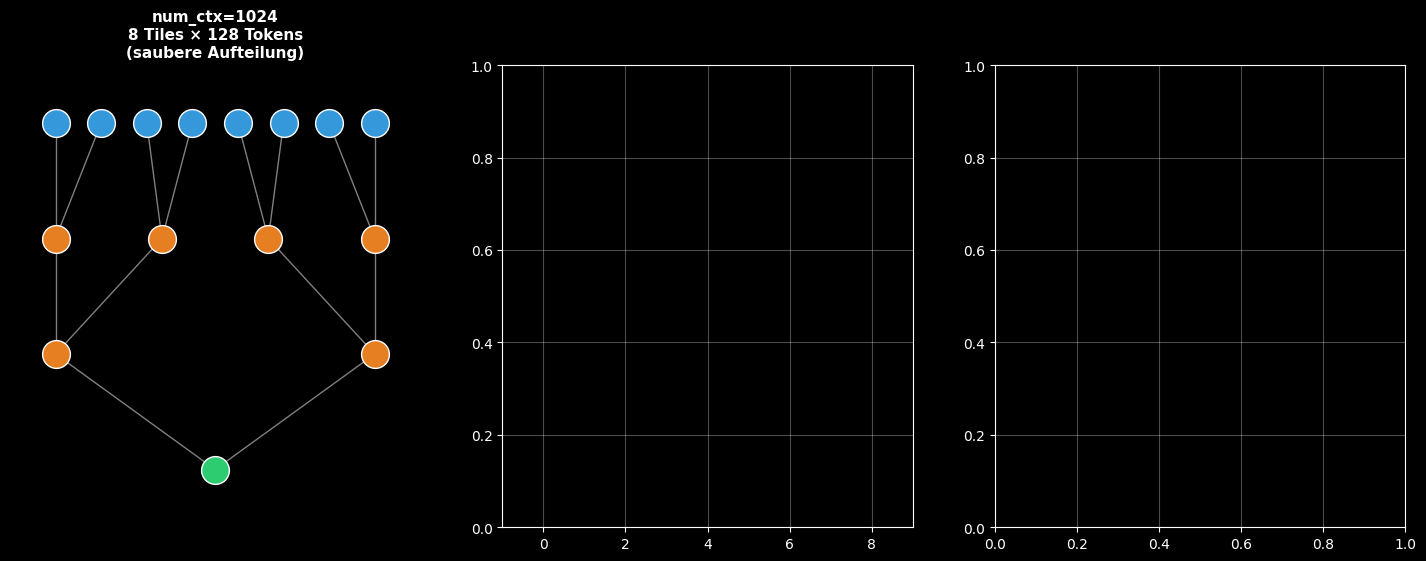

In [27]:
def visualize_reduction_tree(n_tiles, ax, title):
    """Zeichnet einen Reduktionsbaum fuer n_tiles Eingabe-Bloecke."""
    ax.set_xlim(-1, n_tiles)

    levels = []
    current = list(range(1, n_tiles + 1))
    levels.append(current)
    while len(current) > 1:
        next_level = []
        for i in range(0, len(current), 2):
            if i + 1 < len(current):
                next_level.append(f'{current[i]}-{current[i+1]}' if isinstance(current[i], int)
                                 else f'{current[i].split("-")[0]}-{current[i+1].split("-")[-1]}')
            else:
                next_level.append(current[i])  # Ungerade Anzahl: Rest
        current = next_level
        levels.append(current)

    total_levels = len(levels)
    ax.set_ylim(-0.5, total_levels - 0.5)

    # Nodes und Kanten zeichnen
    node_positions = {}  # (level, idx) -> x
    for level_idx, level in enumerate(levels):
        y = total_levels - 1 - level_idx
        n = len(level)
        spacing = (n_tiles - 1) / max(n - 1, 1) if n > 1 else 0
        start_x = (n_tiles - 1) / 2 - spacing * (n - 1) / 2

        for i, label in enumerate(level):
            x = start_x + i * spacing
            node_positions[(level_idx, i)] = x

            color = '#3498db' if level_idx == 0 else '#e67e22' if level_idx < total_levels - 1 else '#2ecc71'
            ax.scatter(x, y, s=400, color=color, zorder=5, edgecolors='white', linewidth=1)
            ax.text(x, y, str(label), ha='center', va='center',
                   fontsize=7 if level_idx == 0 else 6, color='white', fontweight='bold')

            # Kanten zu Kindern
            if level_idx > 0:
                parent_idx = level_idx - 1
                child_base = i * 2
                for c in [child_base, child_base + 1]:
                    if (parent_idx, c) in node_positions:
                        cx = node_positions[(parent_idx, c)]
                        cy = total_levels - 1 - parent_idx
                        ax.plot([cx, x], [cy, y], color='white', alpha=0.5, lw=1)

    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.axis('off')


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

visualize_reduction_tree(8, axes[0], 'num_ctx=1024\n8 Tiles × 128 Tokens\n(saubere Aufteilung)')
visualize_reduction_tree(9, axes[1], 'num_ctx=1023\n7 Tiles + 1 Rest-Tile\n(Padding noetig)')
visualize_reduction_tree(16, axes[2], 'num_ctx=2048\n16 Tiles × 128 Tokens\n(anderer Baum!)')

plt.suptitle('GPU-Reduktionsbaeume: Unterschiedliches num_ctx → unterschiedliche Baumstruktur\n'
             '→ unterschiedliche Float-Rundung → potenziell unterschiedliche Logits',
             fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
def simulate_tiling_effect():
    """Simuliert den Effekt verschiedener Tile-Groessen auf die Attention-Berechnung."""
    np.random.seed(42)

    # Simulierte Attention-Scores (wie sie in Flash Attention vorkommen)
    context_sizes = [512, 1024, 1023, 2048, 4096]
    tile_size = 128

    print("=" * 70)
    print("Simulation: Wie Tile-Groesse die Berechnung beeinflusst")
    print("=" * 70)

    base_scores = np.random.randn(4096).astype(np.float32)

    results = {}
    for ctx in context_sizes:
        scores = base_scores[:ctx]
        n_tiles = (ctx + tile_size - 1) // tile_size
        has_rest = ctx % tile_size != 0
        rest_size = ctx % tile_size if has_rest else tile_size

        result = tree_reduce(scores, tile_size)
        results[ctx] = result

        rest_info = f" + Rest-Tile ({rest_size})" if has_rest else " (sauber)"
        print(f"  num_ctx={ctx:>4}: {n_tiles:>2} Tiles{rest_info:<20}  Summe = {result:.10f}")

    # Vergleich: 1024 vs 1023
    if 1024 in results and 1023 in results:
        diff = abs(results[1024] - results[1023])
        print(f"\n  Differenz 1024 vs 1023: {diff:.2e}")
        print(f"  → Nur 1 Token Unterschied im Context, aber anderes Ergebnis!")

simulate_tiling_effect()

---
## 6. Der Schmetterlingseffekt: Ein Token kippt alles

Autoregressive Generierung ist eine **Kette**: Jedes Token wird basierend auf **allen bisherigen** Tokens gewaehlt.
Wenn ein einziges Token abweicht, divergiert der gesamte restliche Text.

Reales Beispiel aus einem Ollama-Test mit `qwen3:8b`:

```
Run 1: "...discovers a mysterious world of digital reality and rebels..."
Run 2: "...discovers the world is a computer simulation and joins a rebellion..."
```

Die Divergenz passiert nach `discovers` – einmal kommt `a`, einmal `the`.
Ab da sind es komplett unterschiedliche Pfade.

In [ ]:
def visualize_butterfly_effect(model, tokenizer, text, max_steps=6):
    """Zeigt wie verschiedene Sampling-Entscheidungen zu divergierenden Pfaden fuehren."""
    model.eval()

    # Greedy-Pfad (temp=0)
    def generate_path(tokens_start, temperature, max_steps):
        tokens = tokens_start.copy()
        path = []
        for _ in range(max_steps):
            with torch.no_grad():
                context = tokens[-5:] if len(tokens) > 5 else tokens
                logits = model(torch.tensor(context).unsqueeze(0))[0, -1, :]
                probs = F.softmax(logits, dim=-1).numpy()

                top2_idx = np.argsort(probs)[-2:][::-1]
                top2_probs = probs[top2_idx]
                gap = top2_probs[0] - top2_probs[1]

                if temperature == 0:
                    next_token = top2_idx[0]
                else:
                    scaled = logits / temperature
                    next_token = torch.multinomial(F.softmax(scaled, dim=-1), 1).item()

            word = tokenizer.idx_to_word.get(next_token, '?')
            path.append({'word': word, 'gap': gap, 'prob': probs[next_token]})
            tokens.append(next_token)

            if word == '<EOS>':
                break
        return path

    tokens_start = tokenizer.encode(text)

    # Generiere mehrere Pfade mit leicht verschiedenen Temperatures
    paths = {
        'Greedy (temp=0)': generate_path(tokens_start, 0, max_steps),
        'Sample 1 (temp=0.5)': generate_path(tokens_start, 0.5, max_steps),
        'Sample 2 (temp=0.8)': generate_path(tokens_start, 0.8, max_steps),
        'Sample 3 (temp=1.0)': generate_path(tokens_start, 1.0, max_steps),
    }

    # Visualisierung
    fig, ax = plt.subplots(figsize=(16, 6))
    colors = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']

    for i, (label, path) in enumerate(paths.items()):
        words = [text] + [p['word'] for p in path]
        full_text = ' '.join(words)
        y = len(paths) - i - 1

        # Hintergrund
        rect = FancyBboxPatch((-0.5, y - 0.35), 15.5, 0.7,
                             boxstyle='round,pad=0.1',
                             facecolor=colors[i], alpha=0.15, edgecolor=colors[i])
        ax.add_patch(rect)

        # Start-Text
        ax.text(-0.3, y, text, fontsize=10, va='center', color='white', fontweight='bold')

        # Generierte Tokens
        x_pos = len(text.split()) * 1.5
        for j, p in enumerate(path):
            alpha = max(0.4, p['prob'])
            ax.text(x_pos, y, p['word'], fontsize=10, va='center',
                   color=colors[i], alpha=alpha, fontweight='bold')
            x_pos += 1.5

        ax.text(15.2, y, label, fontsize=8, va='center', color=colors[i], ha='right')

    ax.set_xlim(-0.5, 15.5)
    ax.set_ylim(-0.5, len(paths) - 0.5)
    ax.axis('off')
    ax.set_title(f'Schmetterlingseffekt: Verschiedene Pfade ab "{text}"\n'
                 'Jede Abweichung fuehrt zu komplett anderem Folgetext',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_butterfly_effect(model, tokenizer, "die katze")
visualize_butterfly_effect(model, tokenizer, "der hund")

---
## 7. Praxis: Determinismus in Ollama & LM Studio

### Ollama (Docker)

```yaml
# docker-compose.yml
services:
  ollama:
    image: ollama/ollama:latest
    ports:
      - "11434:11434"
    volumes:
      - ollama_data:/root/.ollama
    deploy:  # Fuer NVIDIA GPU – weglassen falls nur CPU
      resources:
        reservations:
          devices:
            - driver: nvidia
              count: all
              capabilities: [gpu]
```

**Determinismus-Parameter** (`temperature`, `seed`, `num_ctx`) werden **pro Request** gesetzt:

```bash
curl -s http://localhost:11434/api/chat -d '{
  "model": "qwen3:8b",
  "messages": [{"role": "user", "content": "Was ist Docker?"}],
  "options": {
    "seed": 123,
    "temperature": 0,
    "num_ctx": 2048
  },
  "stream": false
}'
```

### LM Studio

**`num_ctx` wird beim Laden des Modells fixiert** (nicht pro Request!):
```bash
lms load qwen3-8b --context-length 4096
```

`temperature` und `seed` werden im API-Request gesetzt (OpenAI-kompatibel):
```bash
curl -s http://localhost:1234/v1/chat/completions -d '{
  "model": "qwen3-8b",
  "messages": [{"role": "user", "content": "Was ist Docker?"}],
  "temperature": 0,
  "seed": 123,
  "stream": false
}'
```

### Vergleich

| Parameter | Ollama | LM Studio |
|---|---|---|
| `temperature` | Per Request (`options.temperature`) | Per Request (`temperature`) |
| `seed` | Per Request (`options.seed`) | Per Request (`seed`) |
| `num_ctx` | **Per Request** (`options.num_ctx`) | **Beim Modell-Laden** (GUI/CLI) |
| API-Stil | Ollama-native | OpenAI-kompatibel |
| Default Port | 11434 | 1234 |

### Hinweis: 100% Determinismus ist auf GPUs nicht moeglich

Selbst bei perfekt identischen Einstellungen kann das **GPU-Thread-Scheduling**
minimal andere Reihenfolgen produzieren. Das ist hardware-bedingt und nicht kontrollierbar.
In der Praxis erreicht man damit ~99% Reproduzierbarkeit – bei den restlichen ~1%
handelt es sich um Stellen, wo zwei Tokens fast identische Logits haben.

---
## 8. Debugging mit logprobs

Ollama (ab v0.12.11) kann **Log-Wahrscheinlichkeiten** zurueckgeben.
Damit laesst sich die exakte Stelle finden, an der die Generierung divergiert.

```bash
curl -s http://localhost:11434/api/chat -d '{
  "model": "qwen3:8b",
  "messages": [{"role": "user", "content": "Beschreibe The Matrix"}],
  "options": {"seed": 123, "temperature": 0, "num_ctx": 2048, "num_predict": 10},
  "logprobs": true,
  "top_logprobs": 5,
  "stream": false
}'
```

### Logprobs lesen

Logprobs sind logarithmische Wahrscheinlichkeiten (`ln(p)`). Umrechnung:

```
logprob = -0.234  →  e^(-0.234) = 0.791  →  79.1%
logprob = -2.891  →  e^(-2.891) = 0.056  →   5.6%
```

Je naeher an 0, desto sicherer das Modell. Wenn der **Gap** zwischen Top-1 und Top-2
kleiner als ~0.001 ist, ist diese Stelle **anfaellig fuer Nichtdeterminismus**.

In [ ]:
def simulate_logprobs(model, tokenizer, text, max_tokens=6):
    """Simuliert logprobs-Ausgabe wie bei Ollama, mit Stabilitaets-Analyse."""
    model.eval()
    tokens = tokenizer.encode(text)
    generated = text.split()

    print(f'Prompt: "{text}"')
    print(f'{"Token":<12} {"logprob":>8} {"Prob":>8} {"Gap":>8}  Status')
    print('-' * 60)

    logprob_data = []

    for step in range(max_tokens):
        with torch.no_grad():
            context = tokens[-5:] if len(tokens) > 5 else tokens
            logits = model(torch.tensor(context).unsqueeze(0))[0, -1, :]
            probs = F.softmax(logits, dim=-1).numpy()

        top2_idx = np.argsort(probs)[-2:][::-1]
        top1_prob = probs[top2_idx[0]]
        top2_prob = probs[top2_idx[1]]
        logprob = np.log(top1_prob + 1e-10)
        gap = np.log(top1_prob + 1e-10) - np.log(top2_prob + 1e-10)

        word = tokenizer.idx_to_word.get(top2_idx[0], '?')
        word2 = tokenizer.idx_to_word.get(top2_idx[1], '?')

        stability = 'STABIL' if gap > 0.5 else 'INSTABIL' if gap < 0.1 else 'GRENZWERTIG'
        marker = '  ' if gap > 0.5 else ' !' if gap < 0.1 else ' ~'

        print(f'{word:<12} {logprob:>8.4f} {top1_prob*100:>7.1f}% {gap:>8.4f} {marker} {stability}')

        logprob_data.append({
            'word': word, 'word2': word2,
            'prob1': top1_prob, 'prob2': top2_prob,
            'gap': gap,
        })

        tokens.append(top2_idx[0])
        generated.append(word)

        if word == '<EOS>':
            break

    print(f'\nGeneriert: "{" ".join(generated)}"')

    # Visualisierung: Gap pro Schritt
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    steps = range(len(logprob_data))
    gaps = [d['gap'] for d in logprob_data]
    words_gen = [d['word'] for d in logprob_data]
    probs1 = [d['prob1'] * 100 for d in logprob_data]
    probs2 = [d['prob2'] * 100 for d in logprob_data]

    # 1. Wahrscheinlichkeiten Top-1 vs Top-2
    ax1.bar([s - 0.15 for s in steps], probs1, 0.3, label='Top-1', color='#2ecc71')
    ax1.bar([s + 0.15 for s in steps], probs2, 0.3, label='Top-2', color='#e74c3c', alpha=0.7)
    ax1.set_ylabel('Wahrscheinlichkeit (%)')
    ax1.set_title('Top-1 vs Top-2 Wahrscheinlichkeit pro Schritt')
    ax1.legend()

    # 2. Gap (Stabilitaet)
    gap_colors = ['#2ecc71' if g > 0.5 else '#e74c3c' if g < 0.1 else '#f39c12' for g in gaps]
    ax2.bar(steps, gaps, color=gap_colors)
    ax2.axhline(y=0.5, color='#2ecc71', linestyle='--', alpha=0.5, label='Stabil (>0.5)')
    ax2.axhline(y=0.1, color='#e74c3c', linestyle='--', alpha=0.5, label='Instabil (<0.1)')
    ax2.set_ylabel('Logprob-Gap')
    ax2.set_xlabel('Generierungsschritt')
    ax2.set_title('Stabilitaet der Token-Wahl (Gap zwischen Top-1 und Top-2)')
    ax2.set_xticks(list(steps))
    ax2.set_xticklabels(words_gen, rotation=45, ha='right')
    ax2.legend()

    plt.suptitle(f'Logprob-Analyse: "{text}"', fontsize=13)
    plt.tight_layout()
    plt.show()

simulate_logprobs(model, tokenizer, "die katze")
simulate_logprobs(model, tokenizer, "der hund")

---
## 9. Zusammenfassung: Kette der Determinismus-Bedingungen

```
Fester num_ctx
    → identisches Speicher-Layout
        → identische Tile-Aufteilung (Flash Attention Blocks)
            → identische Reduktionsbaum-Struktur
                → identische Float-Rundung

Fester seed
    → identischer Zufallsgenerator-Zustand

temperature = 0
    → Greedy Decoding (kein Sampling)

Alle drei zusammen → identische Logits → identische Token-Wahl → identischer Output
```

**Restrisiko**: GPU-Thread-Scheduling ist nicht-deterministisch.
In ~1% der Faelle koennen zwei Tokens fast identische Logits haben
und die Rangfolge kippt. Das ist hardware-bedingt und nicht vermeidbar.

### AI SDK 6 Integration

```typescript
// ai-sdk-ollama: num_ctx direkt in den Model-Options
import { createOllama } from 'ai-sdk-ollama';
import { generateText } from 'ai';

const ollama = createOllama({ baseURL: process.env.LLM_PROVIDER_URL });

const { text } = await generateText({
  model: ollama('qwen3:8b', { options: { num_ctx: 2048 } }),
  temperature: 0,
  seed: 123,
  prompt: 'Was ist Docker?',
});
```

In [ ]:
def summary_visualization():
    """Zusammenfassung als Infografik."""
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Titel
    ax.text(7, 9.5, 'Determinismus-Rezept fuer lokale LLMs',
           ha='center', fontsize=16, fontweight='bold', color='white')

    # Drei Saeulen
    pillars = [
        (2.5, '#e74c3c', 'temperature = 0',
         'Greedy Decoding:\nImmer das Token\nmit dem hoechsten\nLogit-Wert',
         'Entfernt\nZufaelligkeit'),
        (7.0, '#3498db', 'seed = 123',
         'Fixer Random State:\nIdentischer\nZufallsgenerator\nbei jedem Run',
         'Fixiert\nSampling'),
        (11.5, '#2ecc71', 'num_ctx = 2048',
         'Festes Context-Window:\nIdentisches Speicher-\nLayout, identische\nTile-Aufteilung',
         'Fixiert\nFloat-Berechnung'),
    ]

    for x, color, param, desc, effect in pillars:
        # Parameter-Box
        rect = FancyBboxPatch((x - 1.8, 7.2), 3.6, 1.2,
                             boxstyle='round,pad=0.15',
                             facecolor=color, edgecolor='white', alpha=0.9)
        ax.add_patch(rect)
        ax.text(x, 7.8, param, ha='center', va='center',
               fontsize=11, fontweight='bold', color='white', family='monospace')

        # Pfeil
        ax.annotate('', xy=(x, 6.0), xytext=(x, 7.2),
                   arrowprops=dict(arrowstyle='->', color='white', lw=2))

        # Beschreibung
        rect2 = FancyBboxPatch((x - 1.8, 3.5), 3.6, 2.5,
                              boxstyle='round,pad=0.15',
                              facecolor=color, edgecolor='white', alpha=0.2)
        ax.add_patch(rect2)
        ax.text(x, 4.8, desc, ha='center', va='center',
               fontsize=9, color='white')

        # Effekt
        ax.annotate('', xy=(x, 2.3), xytext=(x, 3.5),
                   arrowprops=dict(arrowstyle='->', color='white', lw=2))
        ax.text(x, 1.8, effect, ha='center', va='center',
               fontsize=10, color=color, fontweight='bold')

    # Ergebnis
    rect_result = FancyBboxPatch((2, 0.2), 10, 1.0,
                                boxstyle='round,pad=0.15',
                                facecolor='#f39c12', edgecolor='white', alpha=0.9)
    ax.add_patch(rect_result)
    ax.text(7, 0.7, 'Identische Logits → Identische Token-Wahl → Identischer Output (~99%)',
           ha='center', va='center', fontsize=11, fontweight='bold', color='black')

    plt.tight_layout()
    plt.show()

summary_visualization()